# 🎬 Video Captioning Training - UCF-Crime Dataset
## S2VT Model with Beam Search & Comprehensive Analysis

**Complete Pipeline:**
1. ✅ Data Loading & Preprocessing
2. ✅ Vocabulary Building
3. ✅ S2VT Model Training with Logging
4. ✅ Beam Search Decoding
5. ✅ Comprehensive Evaluation (BLEU, METEOR, ROUGE, CIDEr)
6. ✅ Visualizations & Analysis
7. ✅ Comparison Charts & Detailed Reports

## 📦 1. Setup & Imports

In [1]:
# Install dependencies
!pip install -q huggingface_hub h5py datasets nltk rouge wordcloud matplotlib seaborn plotly

import warnings
warnings.filterwarnings('ignore')

print("✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.
✓ Dependencies installed


In [2]:
# Download NLTK data
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
print("✓ NLTK data downloaded")

✓ NLTK data downloaded


In [3]:
# Core imports
from huggingface_hub import hf_hub_download
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import pickle
import json
import re
from collections import Counter, defaultdict
from typing import List, Dict, Tuple
import os
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Evaluation metrics
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All imports successful")

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️  Using device: {device}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✓ All imports successful

🖥️  Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


In [4]:
# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/plots', exist_ok=True)
os.makedirs('outputs/models', exist_ok=True)
os.makedirs('outputs/logs', exist_ok=True)

# Initialize logging
log_file = f'outputs/logs/training_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'

def log(message, level='INFO'):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    log_msg = f"[{timestamp}] [{level}] {message}"
    print(log_msg)
    with open(log_file, 'a') as f:
        f.write(log_msg + '\n')

log("Training session started", 'INFO')
log(f"Device: {device}", 'INFO')
print(f"\n📝 Logs will be saved to: {log_file}")

[2025-11-30 11:41:49] [INFO] Training session started
[2025-11-30 11:41:49] [INFO] Device: cuda

📝 Logs will be saved to: outputs/logs/training_20251130_114149.log


## 📊 2. Data Loader

In [5]:
class UCFCrimeDataset(Dataset):
    """Dataset class for loading UCF-Crime features with sentences."""
    
    def __init__(self, hdf5_path, split=None):
        self.hdf5_path = hdf5_path
        self.hdf5_file = h5py.File(hdf5_path, 'r')
        
        # Build list of video paths
        self.video_paths = []
        for category_name in self.hdf5_file.keys():
            for video_name in self.hdf5_file[category_name].keys():
                self.video_paths.append(f"{category_name}/{video_name}")
        
        # Filter by split
        if split is not None:
            filtered = []
            for vp in self.video_paths:
                s = self.hdf5_file[vp].attrs.get('split', 'Unknown')
                if isinstance(s, bytes):
                    s = s.decode('utf-8')
                if s.lower() == split.lower():
                    filtered.append(vp)
            self.video_paths = filtered
            log(f"Loaded {len(self.video_paths)} videos for split: {split}", 'INFO')
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        vg = self.hdf5_file[self.video_paths[idx]]
        
        features = torch.from_numpy(np.array(vg['features'])).float()
        labels = torch.from_numpy(np.array(vg['labels'])).float()
        
        # Load sentences
        sents_raw = vg['sentences'][:]
        sentences = [s.decode('utf-8') if isinstance(s, bytes) else str(s) for s in sents_raw]
        
        return {
            'video_id': self.video_paths[idx],
            'features': features,
            'labels': labels,
            'sentences': sentences
        }
    
    def close(self):
        if self.hdf5_file:
            self.hdf5_file.close()

def collate_fn(batch):
    return {
        'video_id': [b['video_id'] for b in batch],
        'features': torch.stack([b['features'] for b in batch]),
        'labels': torch.stack([b['labels'] for b in batch]),
        'sentences': [b['sentences'] for b in batch]
    }

log("Dataset class defined", 'SUCCESS')

[2025-11-30 11:41:49] [SUCCESS] Dataset class defined


In [6]:
# Download dataset
log("Downloading dataset from HuggingFace...", 'INFO')
hdf5_path = hf_hub_download(
    repo_id="Rahima411/ucf-anomaly-detection-mapped",
    filename="ucf_crime_features_labeled.h5",
    repo_type="dataset"
)
log(f"Dataset downloaded to: {hdf5_path}", 'SUCCESS')

# Create datasets
train_dataset = UCFCrimeDataset(hdf5_path, split='Train')
val_dataset = UCFCrimeDataset(hdf5_path, split='Val')
test_dataset = UCFCrimeDataset(hdf5_path, split='Test')

# Dataset statistics
print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"Training:   {len(train_dataset):>5} videos")
print(f"Validation: {len(val_dataset):>5} videos")
print(f"Test:       {len(test_dataset):>5} videos")
print(f"Total:      {len(train_dataset) + len(val_dataset) + len(test_dataset):>5} videos")
print("="*60)

# Sample video
sample = train_dataset[0]
log(f"Sample video: {sample['video_id']}", 'INFO')
log(f"  Features shape: {sample['features'].shape}", 'INFO')
log(f"  Number of sentences: {len(sample['sentences'])}", 'INFO')
log(f"  First sentence: {sample['sentences'][0][:80]}...", 'INFO')

[2025-11-30 11:41:49] [INFO] Downloading dataset from HuggingFace...


ucf_crime_features_labeled.h5:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

[2025-11-30 11:41:50] [SUCCESS] Dataset downloaded to: /root/.cache/huggingface/hub/datasets--Rahima411--ucf-anomaly-detection-mapped/snapshots/46b5521504947dac3e45133418591b7c3e0e90a2/ucf_crime_features_labeled.h5
[2025-11-30 11:41:50] [INFO] Loaded 560 videos for split: Train
[2025-11-30 11:41:50] [INFO] Loaded 149 videos for split: Val
[2025-11-30 11:41:50] [INFO] Loaded 184 videos for split: Test

DATASET STATISTICS
Training:     560 videos
Validation:   149 videos
Test:         184 videos
Total:        893 videos
[2025-11-30 11:41:50] [INFO] Sample video: abuse/Abuse001_x264
[2025-11-30 11:41:50] [INFO]   Features shape: torch.Size([7, 1024])
[2025-11-30 11:41:50] [INFO]   Number of sentences: 9
[2025-11-30 11:41:50] [INFO]   First sentence: A woman with short hair, slightly fat, wearing a white top and black pants stood...


## 📚 3. Build Vocabulary

In [7]:
class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<START>', 2: '<END>', 3: '<UNK>'}
        self.word_freq = Counter()
        self.idx = 4
    
    @staticmethod
    def tokenize(sentence):
        sentence = sentence.lower()
        sentence = re.sub(r"[^a-z0-9'\s]", '', sentence)
        return sentence.split()
    
    def build_vocabulary(self, sentences):
        for sentence in sentences:
            for token in self.tokenize(sentence):
                self.word_freq[token] += 1
        
        for word, freq in self.word_freq.items():
            if freq >= self.freq_threshold and word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1
        
        log(f"Vocabulary built: {len(self.word2idx)} words", 'SUCCESS')
    
    def encode(self, sentence, max_length=None):
        tokens = [self.word2idx['<START>']] + \
                 [self.word2idx.get(t, self.word2idx['<UNK>']) for t in self.tokenize(sentence)] + \
                 [self.word2idx['<END>']]
        if max_length and len(tokens) > max_length:
            tokens = tokens[:max_length-1] + [self.word2idx['<END>']]
        return tokens
    
    def decode(self, indices):
        words = []
        for idx in indices:
            if idx in self.idx2word:
                word = self.idx2word[idx]
                if word not in ['<PAD>', '<START>', '<END>']:
                    words.append(word)
        return ' '.join(words)
    
    def __len__(self):
        return len(self.word2idx)

log("Vocabulary class defined", 'SUCCESS')

[2025-11-30 11:41:50] [SUCCESS] Vocabulary class defined


In [8]:
# Extract all sentences
log("Extracting sentences from training set...", 'INFO')
all_sentences = []
for i in tqdm(range(len(train_dataset)), desc="Extracting sentences"):
    all_sentences.extend(train_dataset[i]['sentences'])

log(f"Total sentences extracted: {len(all_sentences):,}", 'INFO')

# Build vocabulary
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(all_sentences)

# Vocabulary statistics
print("\n" + "="*60)
print("VOCABULARY STATISTICS")
print("="*60)
print(f"Total unique words: {len(vocab.word_freq):,}")
print(f"Vocabulary size (freq ≥ 5): {len(vocab):,}")
print(f"Coverage: {len(vocab) / len(vocab.word_freq) * 100:.1f}%")
print("\nMost common words:")
for word, freq in vocab.word_freq.most_common(20):
    print(f"  {word:15s} : {freq:>5,}")
print("="*60)

# Save vocabulary
with open('outputs/vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab, f)
log("Vocabulary saved to outputs/vocabulary.pkl", 'SUCCESS')

[2025-11-30 11:41:50] [INFO] Extracting sentences from training set...


Extracting sentences:   0%|          | 0/560 [00:00<?, ?it/s]

[2025-11-30 11:41:51] [INFO] Total sentences extracted: 4,897
[2025-11-30 11:41:51] [SUCCESS] Vocabulary built: 915 words

VOCABULARY STATISTICS
Total unique words: 2,363
Vocabulary size (freq ≥ 5): 915
Coverage: 38.7%

Most common words:
  the             : 12,269
  and             : 3,961
  a               : 3,743
  man             : 3,339
  in              : 3,309
  to              : 2,271
  of              : 1,613
  on              : 1,365
  black           : 1,294
  car             : 1,177
  white           : 1,105
  walked          : 1,088
  woman           :   902
  with            :   845
  out             :   673
  two             :   666
  door            :   633
  at              :   623
  his             :   596
  left            :   536
[2025-11-30 11:41:51] [SUCCESS] Vocabulary saved to outputs/vocabulary.pkl


## 🧠 4. S2VT Model

In [9]:
class S2VT(nn.Module):
    """Sequence to Sequence - Video to Text (S2VT) Model"""
    
    def __init__(self, feature_dim=1024, embedding_dim=512, hidden_dim=512, 
                 vocab_size=10000, num_layers=1, dropout=0.5):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        # Encoder: Video features → Hidden states
        self.feature_proj = nn.Linear(feature_dim, hidden_dim)
        self.encoder_lstm = nn.LSTM(
            hidden_dim, hidden_dim, num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Decoder: Hidden states + Words → Next words
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.decoder_lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, features, captions):
        """Training forward pass"""
        # Encode video features
        features = self.dropout(self.feature_proj(features))
        _, hidden = self.encoder_lstm(features)
        
        # Decode to captions
        embedded = self.dropout(self.embedding(captions))
        outputs, _ = self.decoder_lstm(embedded, hidden)
        outputs = self.fc_out(outputs)
        
        return outputs
    
    def generate_greedy(self, features, start_idx, end_idx, max_len=30):
        """Greedy decoding (baseline)"""
        batch_size = features.size(0)
        
        # Encode
        features = self.feature_proj(features)
        _, hidden = self.encoder_lstm(features)
        
        # Generate
        input_word = torch.full((batch_size,), start_idx, dtype=torch.long, device=features.device)
        captions = torch.zeros(batch_size, max_len, dtype=torch.long, device=features.device)
        
        for t in range(max_len):
            embedded = self.embedding(input_word).unsqueeze(1)
            output, hidden = self.decoder_lstm(embedded, hidden)
            output = self.fc_out(output.squeeze(1))
            predicted = output.argmax(1)
            captions[:, t] = predicted
            input_word = predicted
            
            if (predicted == end_idx).all():
                break
        
        return captions

# Create model
model = S2VT(
    feature_dim=1024,
    embedding_dim=512,
    hidden_dim=512,
    vocab_size=len(vocab),
    num_layers=1,
    dropout=0.5
).to(device)

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(f"Model: S2VT (Sequence-to-Sequence Video-to-Text)")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1e6:.2f} MB (fp32)")
print("="*60)

log(f"Model created with {trainable_params:,} parameters", 'SUCCESS')


MODEL ARCHITECTURE
Model: S2VT (Sequence-to-Sequence Video-to-Text)
Total parameters: 5,665,171
Trainable parameters: 5,665,171
Model size: 22.66 MB (fp32)
[2025-11-30 11:41:51] [SUCCESS] Model created with 5,665,171 parameters


## 🏋️ 5. Training Loop with Logging

In [10]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
MAX_LEN = 30
GRAD_CLIP = 5.0

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=0, 
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    collate_fn=collate_fn, 
    num_workers=0, 
    pin_memory=True
)

# Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>'])

log(f"Training configuration:", 'INFO')
log(f"  Batch size: {BATCH_SIZE}", 'INFO')
log(f"  Epochs: {NUM_EPOCHS}", 'INFO')
log(f"  Learning rate: {LEARNING_RATE}", 'INFO')
log(f"  Gradient clip: {GRAD_CLIP}", 'INFO')
log(f"  Train batches: {len(train_loader)}", 'INFO')
log(f"  Val batches: {len(val_loader)}", 'INFO')

[2025-11-30 11:41:57] [INFO] Training configuration:
[2025-11-30 11:41:57] [INFO]   Batch size: 32
[2025-11-30 11:41:57] [INFO]   Epochs: 50
[2025-11-30 11:41:57] [INFO]   Learning rate: 0.0001
[2025-11-30 11:41:57] [INFO]   Gradient clip: 5.0
[2025-11-30 11:41:57] [INFO]   Train batches: 18
[2025-11-30 11:41:57] [INFO]   Val batches: 5


In [11]:
def prepare_captions(sentences_list, vocab, max_len=30):
    """Convert sentences to padded tensor of IDs."""
    # Use first sentence from each video
    sentences = [s[0] if len(s) > 0 else "a video" for s in sentences_list]
    
    # Encode
    encoded = [vocab.encode(s, max_length=max_len) for s in sentences]
    
    # Pad
    max_length = max(len(e) for e in encoded)
    padded = []
    for e in encoded:
        padded.append(e + [vocab.word2idx['<PAD>']] * (max_length - len(e)))
    
    return torch.tensor(padded, dtype=torch.long)

log("Helper functions defined", 'SUCCESS')

[2025-11-30 11:41:57] [SUCCESS] Helper functions defined


In [12]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rates': [],
    'epoch_times': []
}

best_val_loss = float('inf')
patience = 10
patience_counter = 0

log("Starting training...", 'INFO')
log("="*60, 'INFO')

import time

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # ==================== TRAINING ====================
    model.train()
    train_loss = 0
    train_steps = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
    for batch in pbar:
        features = batch['features'].to(device)
        sentences = batch['sentences']
        
        caption_ids = prepare_captions(sentences, vocab, MAX_LEN).to(device)
        
        # Forward
        outputs = model(features, caption_ids[:, :-1])
        loss = criterion(
            outputs.reshape(-1, len(vocab)), 
            caption_ids[:, 1:].reshape(-1)
        )
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        
        train_loss += loss.item()
        train_steps += 1
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    train_loss /= train_steps
    
    # ==================== VALIDATION ====================
    model.eval()
    val_loss = 0
    val_steps = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
        for batch in pbar:
            features = batch['features'].to(device)
            sentences = batch['sentences']
            caption_ids = prepare_captions(sentences, vocab, MAX_LEN).to(device)
            
            outputs = model(features, caption_ids[:, :-1])
            loss = criterion(
                outputs.reshape(-1, len(vocab)), 
                caption_ids[:, 1:].reshape(-1)
            )
            val_loss += loss.item()
            val_steps += 1
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    val_loss /= val_steps
    epoch_time = time.time() - epoch_start
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    history['epoch_times'].append(epoch_time)
    
    # Logging
    log(f"Epoch {epoch+1}/{NUM_EPOCHS} - Time: {epoch_time:.1f}s", 'INFO')
    log(f"  Train Loss: {train_loss:.4f}", 'INFO')
    log(f"  Val Loss:   {val_loss:.4f}", 'INFO')
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'vocab': vocab,
            'history': history
        }, 'outputs/models/best_model.pth')
        
        log(f"  ✓ Best model saved (val_loss: {val_loss:.4f})", 'SUCCESS')
    else:
        patience_counter += 1
        log(f"  Patience: {patience_counter}/{patience}", 'WARNING')
    
    # Early stopping
    if patience_counter >= patience:
        log(f"Early stopping triggered at epoch {epoch+1}", 'WARNING')
        break
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, f'outputs/models/checkpoint_epoch_{epoch+1}.pth')
        log(f"  Checkpoint saved at epoch {epoch+1}", 'INFO')

log("="*60, 'INFO')
log("Training complete!", 'SUCCESS')
log(f"Best validation loss: {best_val_loss:.4f}", 'SUCCESS')

# Save final history
with open('outputs/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)
log("Training history saved", 'SUCCESS')

[2025-11-30 11:41:57] [INFO] Starting training...
[2025-11-30 11:41:57] [INFO] ============================================================


Epoch 1/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:41:59] [INFO] Epoch 1/50 - Time: 2.3s
[2025-11-30 11:41:59] [INFO]   Train Loss: 6.7294
[2025-11-30 11:41:59] [INFO]   Val Loss:   6.5553
[2025-11-30 11:41:59] [SUCCESS]   ✓ Best model saved (val_loss: 6.5553)


Epoch 2/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:00] [INFO] Epoch 2/50 - Time: 1.1s
[2025-11-30 11:42:00] [INFO]   Train Loss: 6.3125
[2025-11-30 11:42:00] [INFO]   Val Loss:   5.9006
[2025-11-30 11:42:00] [SUCCESS]   ✓ Best model saved (val_loss: 5.9006)


Epoch 3/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:01] [INFO] Epoch 3/50 - Time: 1.1s
[2025-11-30 11:42:01] [INFO]   Train Loss: 5.3353
[2025-11-30 11:42:01] [INFO]   Val Loss:   4.8544
[2025-11-30 11:42:02] [SUCCESS]   ✓ Best model saved (val_loss: 4.8544)


Epoch 4/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:03] [INFO] Epoch 4/50 - Time: 1.1s
[2025-11-30 11:42:03] [INFO]   Train Loss: 4.5480
[2025-11-30 11:42:03] [INFO]   Val Loss:   4.5477
[2025-11-30 11:42:03] [SUCCESS]   ✓ Best model saved (val_loss: 4.5477)


Epoch 5/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:04] [INFO] Epoch 5/50 - Time: 1.1s
[2025-11-30 11:42:04] [INFO]   Train Loss: 4.3309
[2025-11-30 11:42:04] [INFO]   Val Loss:   4.4183
[2025-11-30 11:42:04] [SUCCESS]   ✓ Best model saved (val_loss: 4.4183)


Epoch 6/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:05] [INFO] Epoch 6/50 - Time: 1.1s
[2025-11-30 11:42:05] [INFO]   Train Loss: 4.2208
[2025-11-30 11:42:05] [INFO]   Val Loss:   4.3308
[2025-11-30 11:42:05] [SUCCESS]   ✓ Best model saved (val_loss: 4.3308)


Epoch 7/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:06] [INFO] Epoch 7/50 - Time: 1.1s
[2025-11-30 11:42:06] [INFO]   Train Loss: 4.1290
[2025-11-30 11:42:06] [INFO]   Val Loss:   4.2616
[2025-11-30 11:42:06] [SUCCESS]   ✓ Best model saved (val_loss: 4.2616)


Epoch 8/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:07] [INFO] Epoch 8/50 - Time: 1.1s
[2025-11-30 11:42:07] [INFO]   Train Loss: 4.0439
[2025-11-30 11:42:07] [INFO]   Val Loss:   4.2065
[2025-11-30 11:42:08] [SUCCESS]   ✓ Best model saved (val_loss: 4.2065)


Epoch 9/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:09] [INFO] Epoch 9/50 - Time: 1.1s
[2025-11-30 11:42:09] [INFO]   Train Loss: 3.9777
[2025-11-30 11:42:09] [INFO]   Val Loss:   4.1495
[2025-11-30 11:42:09] [SUCCESS]   ✓ Best model saved (val_loss: 4.1495)


Epoch 10/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:10] [INFO] Epoch 10/50 - Time: 1.1s
[2025-11-30 11:42:10] [INFO]   Train Loss: 3.9172
[2025-11-30 11:42:10] [INFO]   Val Loss:   4.1024
[2025-11-30 11:42:10] [SUCCESS]   ✓ Best model saved (val_loss: 4.1024)
[2025-11-30 11:42:10] [INFO]   Checkpoint saved at epoch 10


Epoch 11/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:11] [INFO] Epoch 11/50 - Time: 1.1s
[2025-11-30 11:42:11] [INFO]   Train Loss: 3.8554
[2025-11-30 11:42:11] [INFO]   Val Loss:   4.0612
[2025-11-30 11:42:11] [SUCCESS]   ✓ Best model saved (val_loss: 4.0612)


Epoch 12/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:12] [INFO] Epoch 12/50 - Time: 1.1s
[2025-11-30 11:42:12] [INFO]   Train Loss: 3.8031
[2025-11-30 11:42:12] [INFO]   Val Loss:   4.0198
[2025-11-30 11:42:12] [SUCCESS]   ✓ Best model saved (val_loss: 4.0198)


Epoch 13/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:14] [INFO] Epoch 13/50 - Time: 1.1s
[2025-11-30 11:42:14] [INFO]   Train Loss: 3.7525
[2025-11-30 11:42:14] [INFO]   Val Loss:   3.9845
[2025-11-30 11:42:14] [SUCCESS]   ✓ Best model saved (val_loss: 3.9845)


Epoch 14/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:15] [INFO] Epoch 14/50 - Time: 1.1s
[2025-11-30 11:42:15] [INFO]   Train Loss: 3.6935
[2025-11-30 11:42:15] [INFO]   Val Loss:   3.9501
[2025-11-30 11:42:15] [SUCCESS]   ✓ Best model saved (val_loss: 3.9501)


Epoch 15/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:16] [INFO] Epoch 15/50 - Time: 1.1s
[2025-11-30 11:42:16] [INFO]   Train Loss: 3.6625
[2025-11-30 11:42:16] [INFO]   Val Loss:   3.9197
[2025-11-30 11:42:16] [SUCCESS]   ✓ Best model saved (val_loss: 3.9197)


Epoch 16/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:17] [INFO] Epoch 16/50 - Time: 1.1s
[2025-11-30 11:42:17] [INFO]   Train Loss: 3.6021
[2025-11-30 11:42:17] [INFO]   Val Loss:   3.8929
[2025-11-30 11:42:17] [SUCCESS]   ✓ Best model saved (val_loss: 3.8929)


Epoch 17/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:18] [INFO] Epoch 17/50 - Time: 1.1s
[2025-11-30 11:42:18] [INFO]   Train Loss: 3.5605
[2025-11-30 11:42:18] [INFO]   Val Loss:   3.8656
[2025-11-30 11:42:19] [SUCCESS]   ✓ Best model saved (val_loss: 3.8656)


Epoch 18/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:20] [INFO] Epoch 18/50 - Time: 1.1s
[2025-11-30 11:42:20] [INFO]   Train Loss: 3.5336
[2025-11-30 11:42:20] [INFO]   Val Loss:   3.8402
[2025-11-30 11:42:20] [SUCCESS]   ✓ Best model saved (val_loss: 3.8402)


Epoch 19/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:21] [INFO] Epoch 19/50 - Time: 1.1s
[2025-11-30 11:42:21] [INFO]   Train Loss: 3.4939
[2025-11-30 11:42:21] [INFO]   Val Loss:   3.8152
[2025-11-30 11:42:21] [SUCCESS]   ✓ Best model saved (val_loss: 3.8152)


Epoch 20/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:22] [INFO] Epoch 20/50 - Time: 1.1s
[2025-11-30 11:42:22] [INFO]   Train Loss: 3.4436
[2025-11-30 11:42:22] [INFO]   Val Loss:   3.7968
[2025-11-30 11:42:22] [SUCCESS]   ✓ Best model saved (val_loss: 3.7968)
[2025-11-30 11:42:22] [INFO]   Checkpoint saved at epoch 20


Epoch 21/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:23] [INFO] Epoch 21/50 - Time: 1.1s
[2025-11-30 11:42:23] [INFO]   Train Loss: 3.4216
[2025-11-30 11:42:23] [INFO]   Val Loss:   3.7732
[2025-11-30 11:42:23] [SUCCESS]   ✓ Best model saved (val_loss: 3.7732)


Epoch 22/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:24] [INFO] Epoch 22/50 - Time: 1.1s
[2025-11-30 11:42:24] [INFO]   Train Loss: 3.3864
[2025-11-30 11:42:24] [INFO]   Val Loss:   3.7537
[2025-11-30 11:42:25] [SUCCESS]   ✓ Best model saved (val_loss: 3.7537)


Epoch 23/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:26] [INFO] Epoch 23/50 - Time: 1.1s
[2025-11-30 11:42:26] [INFO]   Train Loss: 3.3631
[2025-11-30 11:42:26] [INFO]   Val Loss:   3.7359
[2025-11-30 11:42:26] [SUCCESS]   ✓ Best model saved (val_loss: 3.7359)


Epoch 24/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:27] [INFO] Epoch 24/50 - Time: 1.1s
[2025-11-30 11:42:27] [INFO]   Train Loss: 3.3279
[2025-11-30 11:42:27] [INFO]   Val Loss:   3.7172
[2025-11-30 11:42:27] [SUCCESS]   ✓ Best model saved (val_loss: 3.7172)


Epoch 25/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:28] [INFO] Epoch 25/50 - Time: 1.1s
[2025-11-30 11:42:28] [INFO]   Train Loss: 3.2907
[2025-11-30 11:42:28] [INFO]   Val Loss:   3.6980
[2025-11-30 11:42:28] [SUCCESS]   ✓ Best model saved (val_loss: 3.6980)


Epoch 26/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:29] [INFO] Epoch 26/50 - Time: 1.1s
[2025-11-30 11:42:29] [INFO]   Train Loss: 3.2684
[2025-11-30 11:42:29] [INFO]   Val Loss:   3.6903
[2025-11-30 11:42:29] [SUCCESS]   ✓ Best model saved (val_loss: 3.6903)


Epoch 27/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:30] [INFO] Epoch 27/50 - Time: 1.1s
[2025-11-30 11:42:30] [INFO]   Train Loss: 3.2480
[2025-11-30 11:42:30] [INFO]   Val Loss:   3.6680
[2025-11-30 11:42:31] [SUCCESS]   ✓ Best model saved (val_loss: 3.6680)


Epoch 28/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:32] [INFO] Epoch 28/50 - Time: 1.1s
[2025-11-30 11:42:32] [INFO]   Train Loss: 3.2056
[2025-11-30 11:42:32] [INFO]   Val Loss:   3.6552
[2025-11-30 11:42:32] [SUCCESS]   ✓ Best model saved (val_loss: 3.6552)


Epoch 29/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:33] [INFO] Epoch 29/50 - Time: 1.1s
[2025-11-30 11:42:33] [INFO]   Train Loss: 3.1790
[2025-11-30 11:42:33] [INFO]   Val Loss:   3.6405
[2025-11-30 11:42:33] [SUCCESS]   ✓ Best model saved (val_loss: 3.6405)


Epoch 30/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:34] [INFO] Epoch 30/50 - Time: 1.1s
[2025-11-30 11:42:34] [INFO]   Train Loss: 3.1525
[2025-11-30 11:42:34] [INFO]   Val Loss:   3.6327
[2025-11-30 11:42:34] [SUCCESS]   ✓ Best model saved (val_loss: 3.6327)
[2025-11-30 11:42:34] [INFO]   Checkpoint saved at epoch 30


Epoch 31/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:35] [INFO] Epoch 31/50 - Time: 1.1s
[2025-11-30 11:42:35] [INFO]   Train Loss: 3.1293
[2025-11-30 11:42:35] [INFO]   Val Loss:   3.6194
[2025-11-30 11:42:36] [SUCCESS]   ✓ Best model saved (val_loss: 3.6194)


Epoch 32/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:37] [INFO] Epoch 32/50 - Time: 1.1s
[2025-11-30 11:42:37] [INFO]   Train Loss: 3.1016
[2025-11-30 11:42:37] [INFO]   Val Loss:   3.6083
[2025-11-30 11:42:37] [SUCCESS]   ✓ Best model saved (val_loss: 3.6083)


Epoch 33/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:38] [INFO] Epoch 33/50 - Time: 1.1s
[2025-11-30 11:42:38] [INFO]   Train Loss: 3.0840
[2025-11-30 11:42:38] [INFO]   Val Loss:   3.5934
[2025-11-30 11:42:38] [SUCCESS]   ✓ Best model saved (val_loss: 3.5934)


Epoch 34/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:39] [INFO] Epoch 34/50 - Time: 1.1s
[2025-11-30 11:42:39] [INFO]   Train Loss: 3.0559
[2025-11-30 11:42:39] [INFO]   Val Loss:   3.5782
[2025-11-30 11:42:39] [SUCCESS]   ✓ Best model saved (val_loss: 3.5782)


Epoch 35/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:40] [INFO] Epoch 35/50 - Time: 1.1s
[2025-11-30 11:42:40] [INFO]   Train Loss: 3.0263
[2025-11-30 11:42:40] [INFO]   Val Loss:   3.5701
[2025-11-30 11:42:40] [SUCCESS]   ✓ Best model saved (val_loss: 3.5701)


Epoch 36/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:41] [INFO] Epoch 36/50 - Time: 1.1s
[2025-11-30 11:42:41] [INFO]   Train Loss: 2.9995
[2025-11-30 11:42:41] [INFO]   Val Loss:   3.5561
[2025-11-30 11:42:42] [SUCCESS]   ✓ Best model saved (val_loss: 3.5561)


Epoch 37/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:43] [INFO] Epoch 37/50 - Time: 1.1s
[2025-11-30 11:42:43] [INFO]   Train Loss: 2.9843
[2025-11-30 11:42:43] [INFO]   Val Loss:   3.5493
[2025-11-30 11:42:43] [SUCCESS]   ✓ Best model saved (val_loss: 3.5493)


Epoch 38/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:44] [INFO] Epoch 38/50 - Time: 1.1s
[2025-11-30 11:42:44] [INFO]   Train Loss: 2.9612
[2025-11-30 11:42:44] [INFO]   Val Loss:   3.5421
[2025-11-30 11:42:44] [SUCCESS]   ✓ Best model saved (val_loss: 3.5421)


Epoch 39/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:45] [INFO] Epoch 39/50 - Time: 1.1s
[2025-11-30 11:42:45] [INFO]   Train Loss: 2.9303
[2025-11-30 11:42:45] [INFO]   Val Loss:   3.5273
[2025-11-30 11:42:45] [SUCCESS]   ✓ Best model saved (val_loss: 3.5273)


Epoch 40/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:46] [INFO] Epoch 40/50 - Time: 1.1s
[2025-11-30 11:42:46] [INFO]   Train Loss: 2.9204
[2025-11-30 11:42:46] [INFO]   Val Loss:   3.5167
[2025-11-30 11:42:46] [SUCCESS]   ✓ Best model saved (val_loss: 3.5167)
[2025-11-30 11:42:46] [INFO]   Checkpoint saved at epoch 40


Epoch 41/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:48] [INFO] Epoch 41/50 - Time: 1.1s
[2025-11-30 11:42:48] [INFO]   Train Loss: 2.8876
[2025-11-30 11:42:48] [INFO]   Val Loss:   3.5158
[2025-11-30 11:42:48] [SUCCESS]   ✓ Best model saved (val_loss: 3.5158)


Epoch 42/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:49] [INFO] Epoch 42/50 - Time: 1.1s
[2025-11-30 11:42:49] [INFO]   Train Loss: 2.8589
[2025-11-30 11:42:49] [INFO]   Val Loss:   3.4990
[2025-11-30 11:42:49] [SUCCESS]   ✓ Best model saved (val_loss: 3.4990)


Epoch 43/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:50] [INFO] Epoch 43/50 - Time: 1.1s
[2025-11-30 11:42:50] [INFO]   Train Loss: 2.8428
[2025-11-30 11:42:50] [INFO]   Val Loss:   3.5009
[2025-11-30 11:42:50] [WARNING]   Patience: 1/10


Epoch 44/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:51] [INFO] Epoch 44/50 - Time: 1.1s
[2025-11-30 11:42:51] [INFO]   Train Loss: 2.8223
[2025-11-30 11:42:51] [INFO]   Val Loss:   3.4886
[2025-11-30 11:42:51] [SUCCESS]   ✓ Best model saved (val_loss: 3.4886)


Epoch 45/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:52] [INFO] Epoch 45/50 - Time: 1.1s
[2025-11-30 11:42:52] [INFO]   Train Loss: 2.7998
[2025-11-30 11:42:52] [INFO]   Val Loss:   3.4790
[2025-11-30 11:42:52] [SUCCESS]   ✓ Best model saved (val_loss: 3.4790)


Epoch 46/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:53] [INFO] Epoch 46/50 - Time: 1.1s
[2025-11-30 11:42:53] [INFO]   Train Loss: 2.7792
[2025-11-30 11:42:53] [INFO]   Val Loss:   3.4692
[2025-11-30 11:42:54] [SUCCESS]   ✓ Best model saved (val_loss: 3.4692)


Epoch 47/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:55] [INFO] Epoch 47/50 - Time: 1.1s
[2025-11-30 11:42:55] [INFO]   Train Loss: 2.7512
[2025-11-30 11:42:55] [INFO]   Val Loss:   3.4668
[2025-11-30 11:42:55] [SUCCESS]   ✓ Best model saved (val_loss: 3.4668)


Epoch 48/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:56] [INFO] Epoch 48/50 - Time: 1.1s
[2025-11-30 11:42:56] [INFO]   Train Loss: 2.7342
[2025-11-30 11:42:56] [INFO]   Val Loss:   3.4585
[2025-11-30 11:42:56] [SUCCESS]   ✓ Best model saved (val_loss: 3.4585)


Epoch 49/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:57] [INFO] Epoch 49/50 - Time: 1.1s
[2025-11-30 11:42:57] [INFO]   Train Loss: 2.7090
[2025-11-30 11:42:57] [INFO]   Val Loss:   3.4451
[2025-11-30 11:42:57] [SUCCESS]   ✓ Best model saved (val_loss: 3.4451)


Epoch 50/50 [Train]:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

[2025-11-30 11:42:58] [INFO] Epoch 50/50 - Time: 1.1s
[2025-11-30 11:42:58] [INFO]   Train Loss: 2.6886
[2025-11-30 11:42:58] [INFO]   Val Loss:   3.4486
[2025-11-30 11:42:58] [WARNING]   Patience: 1/10
[2025-11-30 11:42:58] [INFO]   Checkpoint saved at epoch 50
[2025-11-30 11:42:58] [INFO] ============================================================
[2025-11-30 11:42:58] [SUCCESS] Training complete!
[2025-11-30 11:42:58] [SUCCESS] Best validation loss: 3.4451
[2025-11-30 11:42:58] [SUCCESS] Training history saved


## 📈 6. Training Visualizations

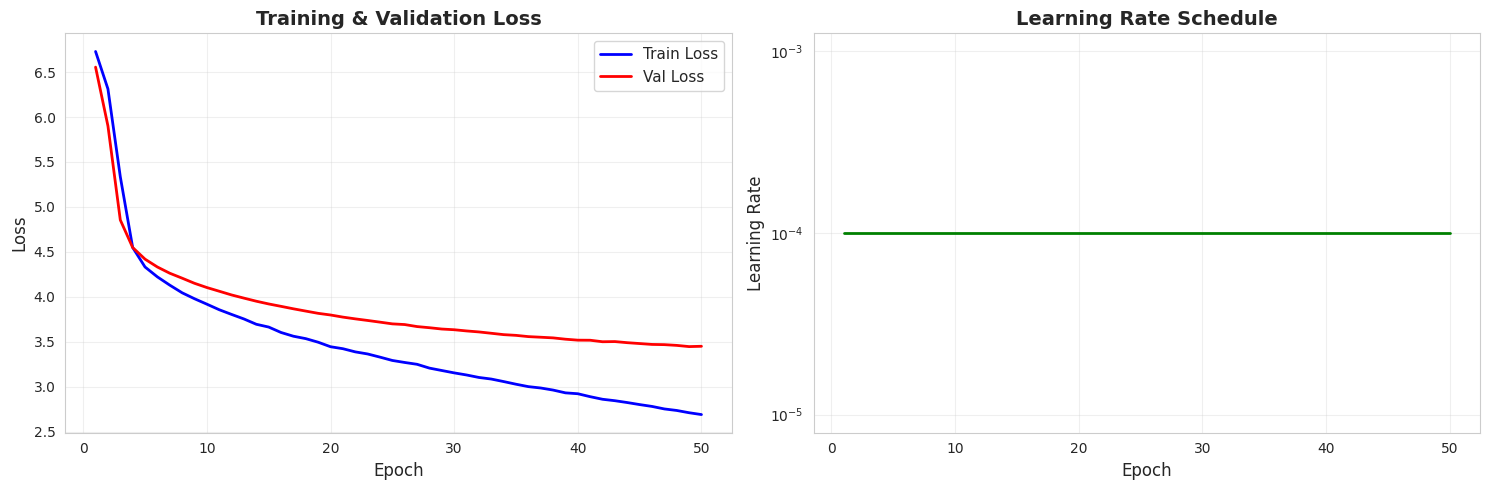

[2025-11-30 11:43:00] [SUCCESS] Training curves saved to outputs/plots/training_curves.png


In [13]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
epochs = range(1, len(history['train_loss']) + 1)
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('outputs/plots/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

log("Training curves saved to outputs/plots/training_curves.png", 'SUCCESS')

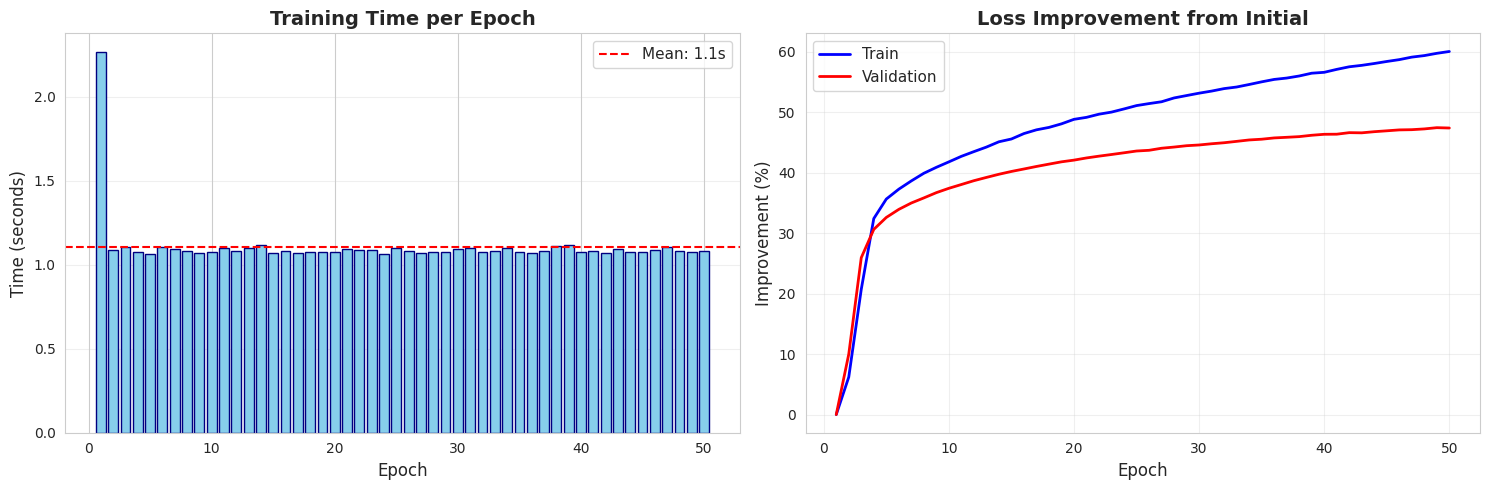


TRAINING SUMMARY
Total epochs trained: 50
Total training time: 0.9 minutes
Average time per epoch: 1.1 seconds

Initial train loss: 6.7294
Final train loss: 2.6886
Train improvement: 60.0%

Initial val loss: 6.5553
Best val loss: 3.4451
Val improvement: 47.4%


In [14]:
# Training statistics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Epoch times
axes[0].bar(epochs, history['epoch_times'], color='skyblue', edgecolor='navy')
axes[0].axhline(np.mean(history['epoch_times']), color='red', linestyle='--', 
                label=f'Mean: {np.mean(history["epoch_times"]):.1f}s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Time (seconds)', fontsize=12)
axes[0].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Loss improvement
train_improvement = [(history['train_loss'][0] - loss) / history['train_loss'][0] * 100 
                     for loss in history['train_loss']]
val_improvement = [(history['val_loss'][0] - loss) / history['val_loss'][0] * 100 
                   for loss in history['val_loss']]

axes[1].plot(epochs, train_improvement, 'b-', label='Train', linewidth=2)
axes[1].plot(epochs, val_improvement, 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Improvement (%)', fontsize=12)
axes[1].set_title('Loss Improvement from Initial', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/training_stats.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total epochs trained: {len(history['train_loss'])}")
print(f"Total training time: {sum(history['epoch_times']) / 60:.1f} minutes")
print(f"Average time per epoch: {np.mean(history['epoch_times']):.1f} seconds")
print(f"\nInitial train loss: {history['train_loss'][0]:.4f}")
print(f"Final train loss: {history['train_loss'][-1]:.4f}")
print(f"Train improvement: {train_improvement[-1]:.1f}%")
print(f"\nInitial val loss: {history['val_loss'][0]:.4f}")
print(f"Best val loss: {min(history['val_loss']):.4f}")
print(f"Val improvement: {max(val_improvement):.1f}%")
print("="*60)

## 🔍 7. Beam Search Implementation

In [15]:
def beam_search_decode(model, features, vocab, beam_size=5, max_len=30, length_penalty=0.6):
    """
    Beam search decoding for high-quality caption generation.
    
    Args:
        model: Trained S2VT model
        features: Video features [1, T, feature_dim] (batch_size MUST be 1)
        vocab: Vocabulary object
        beam_size: Number of beams to keep
        max_len: Maximum caption length
        length_penalty: Penalty for length (higher = prefer longer captions)
    
    Returns:
        Best sequence as list of token indices
    """
    device = features.device
    
    # Encode features
    features_proj = model.feature_proj(features)
    _, hidden = model.encoder_lstm(features_proj)
    
    # Initialize
    start_token = vocab.word2idx['<START>']
    end_token = vocab.word2idx['<END>']
    
    # Beams: (sequence, score, hidden_state)
    beams = [([start_token], 0.0, hidden)]
    completed = []
    
    for step in range(max_len):
        candidates = []
        
        for sequence, score, h in beams:
            # Skip if sequence is complete
            if sequence[-1] == end_token:
                completed.append((sequence, score))
                continue
            
            # Get next token probabilities
            input_word = torch.tensor([sequence[-1]], device=device)
            embedded = model.embedding(input_word).unsqueeze(1)
            output, new_h = model.decoder_lstm(embedded, h)
            logits = model.fc_out(output.squeeze(1))
            log_probs = F.log_softmax(logits, dim=-1)
            
            # Get top-k tokens
            top_log_probs, top_indices = log_probs.topk(beam_size)
            
            # Create candidates
            for i in range(beam_size):
                token = top_indices[0, i].item()
                token_score = top_log_probs[0, i].item()
                
                new_sequence = sequence + [token]
                new_score = score + token_score
                
                candidates.append((new_sequence, new_score, new_h))
        
        # Keep top beam_size candidates
        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_size]
        
        if len(beams) == 0:
            break
    
    # Add remaining beams to completed
    completed.extend(beams)
    
    # Return best sequence with length penalty
    if len(completed) == 0:
        return [start_token, end_token]
    
    # Normalize by length with penalty
    best = max(completed, key=lambda x: x[1] / (len(x[0]) ** length_penalty))
    return best[0]

log("Beam search decoder defined", 'SUCCESS')

[2025-11-30 11:43:02] [SUCCESS] Beam search decoder defined


## 🎯 8. Evaluation with Beam Search

In [19]:
# Load best model
log("Loading best model for evaluation...", 'INFO')
checkpoint = torch.load(
    '/kaggle/working/outputs/models/best_model.pth',
    weights_only=False
)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
log(f"Best model loaded from epoch {checkpoint['epoch']+1}", 'SUCCESS')

# Create test loader
test_loader = DataLoader(
    test_dataset, 
    batch_size=1,  # Batch size 1 for beam search
    shuffle=False, 
    collate_fn=collate_fn, 
    num_workers=0
)

[2025-11-30 12:13:17] [INFO] Loading best model for evaluation...
[2025-11-30 12:13:17] [SUCCESS] Best model loaded from epoch 49


In [20]:
# Generate captions with GREEDY (baseline)
log("Generating captions with GREEDY decoding (baseline)...", 'INFO')
greedy_predictions = []
greedy_references = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Greedy decoding"):
        features = batch['features'].to(device)
        sentences = batch['sentences']
        
        generated = model.generate_greedy(
            features,
            start_idx=vocab.word2idx['<START>'],
            end_idx=vocab.word2idx['<END>'],
            max_len=30
        )
        
        pred = vocab.decode(generated[0].tolist())
        greedy_predictions.append(pred)
        
        refs = sentences[0] if len(sentences[0]) > 0 else ["a video"]
        greedy_references.append(refs)

log(f"Generated {len(greedy_predictions)} greedy captions", 'SUCCESS')

[2025-11-30 12:13:23] [INFO] Generating captions with GREEDY decoding (baseline)...


Greedy decoding:   0%|          | 0/184 [00:00<?, ?it/s]

[2025-11-30 12:13:25] [SUCCESS] Generated 184 greedy captions


In [21]:
# Generate captions with BEAM SEARCH
log("Generating captions with BEAM SEARCH (beam_size=5)...", 'INFO')
beam_predictions = []
beam_references = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Beam search"):
        features = batch['features'].to(device)
        sentences = batch['sentences']
        
        # Beam search
        sequence = beam_search_decode(
            model,
            features,
            vocab,
            beam_size=5,
            max_len=30,
            length_penalty=0.6
        )
        
        pred = vocab.decode(sequence)
        beam_predictions.append(pred)
        
        refs = sentences[0] if len(sentences[0]) > 0 else ["a video"]
        beam_references.append(refs)

log(f"Generated {len(beam_predictions)} beam search captions", 'SUCCESS')

[2025-11-30 12:13:27] [INFO] Generating captions with BEAM SEARCH (beam_size=5)...


Beam search:   0%|          | 0/184 [00:00<?, ?it/s]

[2025-11-30 12:13:41] [SUCCESS] Generated 184 beam search captions


## 📊 9. Compute All Metrics

In [22]:
def compute_all_metrics(predictions, references, name=""):
    """Compute BLEU, METEOR, ROUGE-L, and CIDEr metrics."""
    
    log(f"Computing metrics for {name}...", 'INFO')
    
    # Tokenize
    pred_tokens = [p.split() for p in predictions]
    ref_tokens = [[r.split() for r in refs] for refs in references]
    
    smoothing = SmoothingFunction()
    
    # BLEU scores
    bleu1 = corpus_bleu(ref_tokens, pred_tokens, weights=(1,0,0,0), 
                        smoothing_function=smoothing.method1) * 100
    bleu2 = corpus_bleu(ref_tokens, pred_tokens, weights=(0.5,0.5,0,0), 
                        smoothing_function=smoothing.method1) * 100
    bleu3 = corpus_bleu(ref_tokens, pred_tokens, weights=(0.33,0.33,0.33,0), 
                        smoothing_function=smoothing.method1) * 100
    bleu4 = corpus_bleu(ref_tokens, pred_tokens, weights=(0.25,0.25,0.25,0.25), 
                        smoothing_function=smoothing.method1) * 100
    
    # METEOR
    meteor_scores = []
    for pred, refs in zip(predictions, references):
        pred_toks = pred.split()
        scores = [meteor_score([r.split()], pred_toks) for r in refs]
        meteor_scores.append(max(scores) if scores else 0)
    meteor = np.mean(meteor_scores) * 100
    
    # ROUGE-L
    rouge = Rouge()
    rouge_scores = []
    for pred, refs in zip(predictions, references):
        if len(pred.strip()) == 0:
            rouge_scores.append(0)
            continue
        scores = []
        for ref in refs:
            if len(ref.strip()) > 0:
                try:
                    score = rouge.get_scores(pred, ref)[0]['rouge-l']['f']
                    scores.append(score)
                except:
                    pass
        rouge_scores.append(max(scores) if scores else 0)
    rouge_l = np.mean(rouge_scores) * 100
    
    # CIDEr (simplified)
    def compute_ngrams(tokens, n):
        return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    
    cider_scores = []
    for pred, refs in zip(pred_tokens, ref_tokens):
        scores = []
        for n in range(1, 5):
            pred_ngrams = set(compute_ngrams(pred, n))
            for ref in refs:
                ref_ngrams = set(compute_ngrams(ref, n))
                if len(pred_ngrams) > 0 and len(ref_ngrams) > 0:
                    overlap = len(pred_ngrams & ref_ngrams)
                    scores.append(overlap / (len(pred_ngrams) + len(ref_ngrams)))
        cider_scores.append(np.mean(scores) if scores else 0)
    cider = np.mean(cider_scores) * 100
    
    results = {
        'BLEU-1': bleu1,
        'BLEU-2': bleu2,
        'BLEU-3': bleu3,
        'BLEU-4': bleu4,
        'METEOR': meteor,
        'ROUGE-L': rouge_l,
        'CIDEr': cider
    }
    
    log(f"Metrics computed for {name}", 'SUCCESS')
    return results

# Compute metrics for both methods
greedy_results = compute_all_metrics(greedy_predictions, greedy_references, "Greedy")
beam_results = compute_all_metrics(beam_predictions, beam_references, "Beam Search")

[2025-11-30 12:14:43] [INFO] Computing metrics for Greedy...
[2025-11-30 12:14:47] [SUCCESS] Metrics computed for Greedy
[2025-11-30 12:14:47] [INFO] Computing metrics for Beam Search...
[2025-11-30 12:14:48] [SUCCESS] Metrics computed for Beam Search


## 📈 10. Results Comparison & Visualization

In [23]:
# Print results table
print("\n" + "="*80)
print("EVALUATION RESULTS COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': list(greedy_results.keys()),
    'Greedy': list(greedy_results.values()),
    'Beam Search': list(beam_results.values()),
    'Improvement': [beam_results[k] - greedy_results[k] for k in greedy_results.keys()]
})

# Add paper baseline
paper_baseline = {
    'BLEU-1': 28.27,
    'BLEU-2': 16.34,
    'BLEU-3': 9.62,
    'BLEU-4': 5.56,
    'METEOR': 10.35,
    'ROUGE-L': 25.38,
    'CIDEr': 15.44
}
comparison_df['Paper (S2VT)'] = [paper_baseline[k] for k in greedy_results.keys()]
comparison_df['vs Paper'] = comparison_df['Beam Search'] - comparison_df['Paper (S2VT)']

print(comparison_df.to_string(index=False))
print("="*80)

# Save results
comparison_df.to_csv('outputs/results_comparison.csv', index=False)
log("Results saved to outputs/results_comparison.csv", 'SUCCESS')

# Save as JSON
results_json = {
    'greedy': greedy_results,
    'beam_search': beam_results,
    'paper_baseline': paper_baseline
}
with open('outputs/results.json', 'w') as f:
    json.dump(results_json, f, indent=2)
log("Results saved to outputs/results.json", 'SUCCESS')


EVALUATION RESULTS COMPARISON
 Metric    Greedy  Beam Search  Improvement  Paper (S2VT)   vs Paper
 BLEU-1 50.430240    55.632410     5.202171         28.27  27.362410
 BLEU-2 32.169670    36.883441     4.713771         16.34  20.543441
 BLEU-3 20.139500    23.474573     3.335073          9.62  13.854573
 BLEU-4 11.559545    13.773133     2.213588          5.56   8.213133
 METEOR 35.243088    33.695626    -1.547462         10.35  23.345626
ROUGE-L 38.632683    36.256054    -2.376630         25.38  10.876054
  CIDEr  4.818610     4.473063    -0.345547         15.44 -10.966937
[2025-11-30 12:14:48] [SUCCESS] Results saved to outputs/results_comparison.csv
[2025-11-30 12:14:48] [SUCCESS] Results saved to outputs/results.json


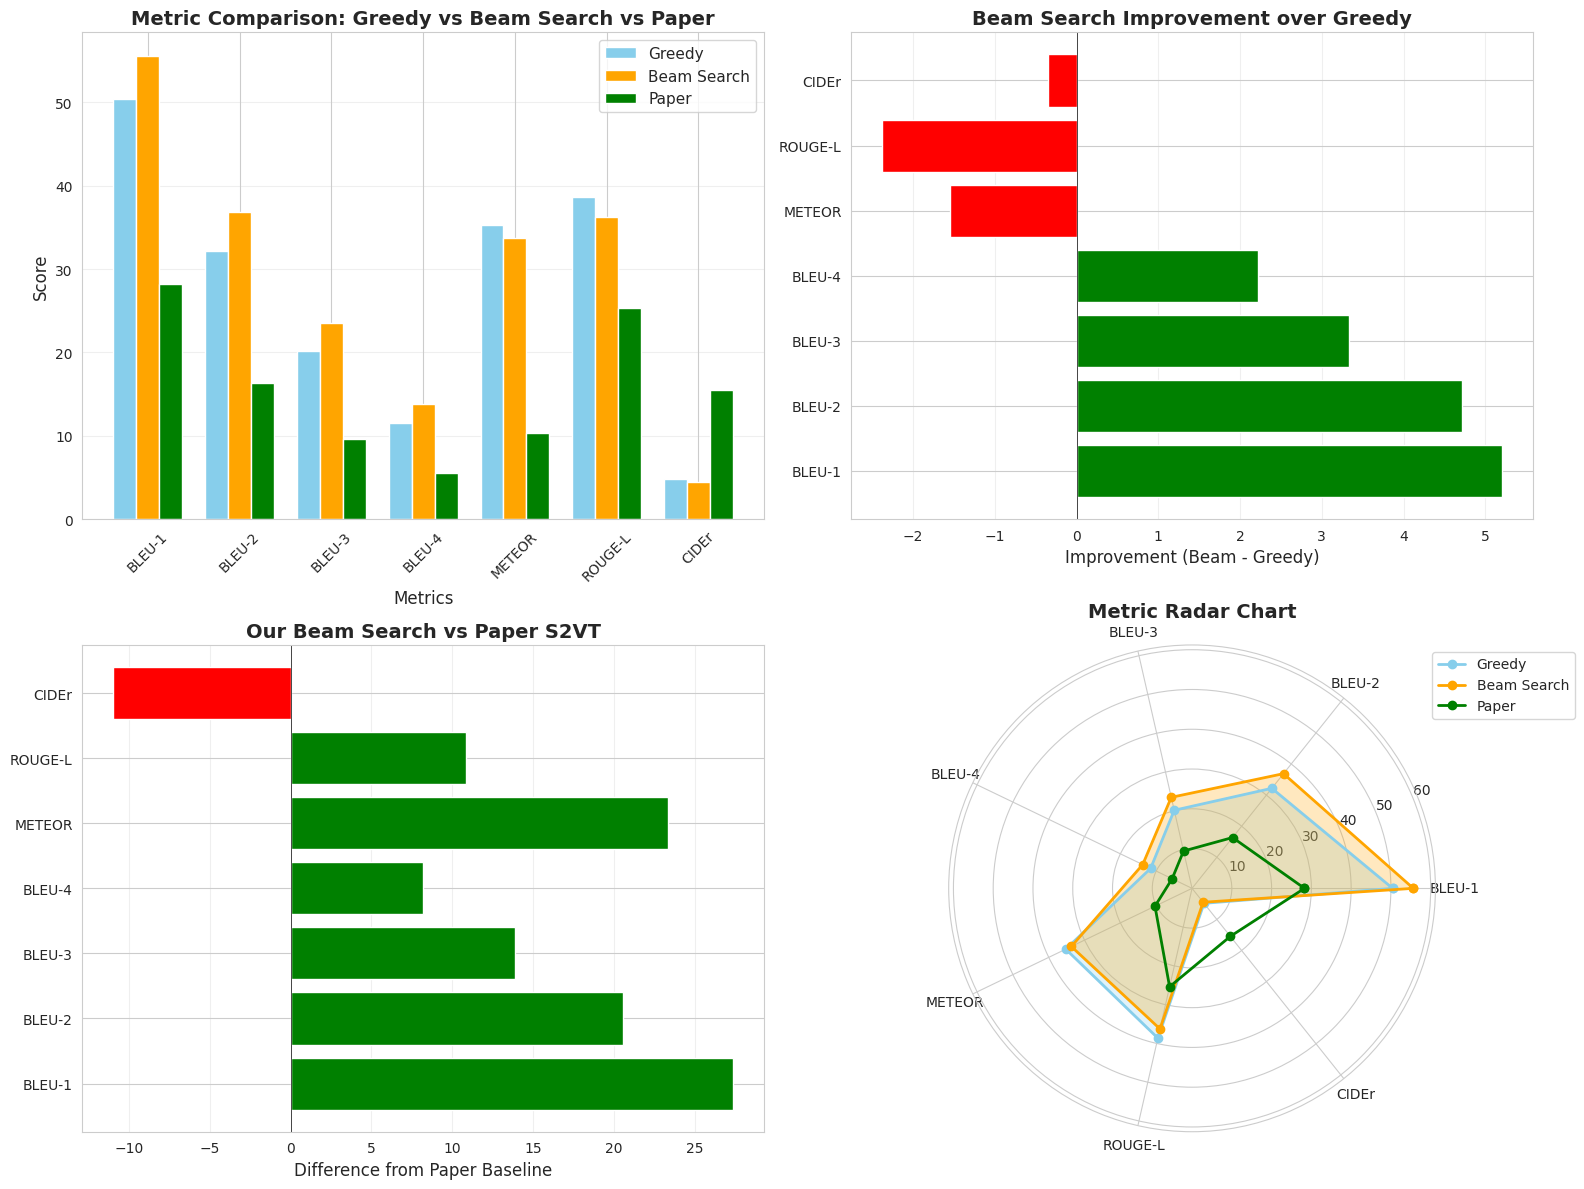

[2025-11-30 12:14:55] [SUCCESS] Metric comparison plots saved


In [24]:
# Visualize metric comparisons
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart comparison
x = np.arange(len(comparison_df))
width = 0.25

axes[0, 0].bar(x - width, comparison_df['Greedy'], width, label='Greedy', color='skyblue')
axes[0, 0].bar(x, comparison_df['Beam Search'], width, label='Beam Search', color='orange')
axes[0, 0].bar(x + width, comparison_df['Paper (S2VT)'], width, label='Paper', color='green')
axes[0, 0].set_xlabel('Metrics', fontsize=12)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Metric Comparison: Greedy vs Beam Search vs Paper', 
                      fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(comparison_df['Metric'], rotation=45)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Improvement over Greedy
colors = ['green' if x > 0 else 'red' for x in comparison_df['Improvement']]
axes[0, 1].barh(comparison_df['Metric'], comparison_df['Improvement'], color=colors)
axes[0, 1].set_xlabel('Improvement (Beam - Greedy)', fontsize=12)
axes[0, 1].set_title('Beam Search Improvement over Greedy', fontsize=14, fontweight='bold')
axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. vs Paper baseline
colors = ['green' if x > 0 else 'red' for x in comparison_df['vs Paper']]
axes[1, 0].barh(comparison_df['Metric'], comparison_df['vs Paper'], color=colors)
axes[1, 0].set_xlabel('Difference from Paper Baseline', fontsize=12)
axes[1, 0].set_title('Our Beam Search vs Paper S2VT', fontsize=14, fontweight='bold')
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Radar chart
from math import pi
categories = list(greedy_results.keys())
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

greedy_vals = list(greedy_results.values()) + [list(greedy_results.values())[0]]
beam_vals = list(beam_results.values()) + [list(beam_results.values())[0]]
paper_vals = [paper_baseline[k] for k in categories] + [paper_baseline[categories[0]]]

ax = plt.subplot(2, 2, 4, projection='polar')
ax.plot(angles, greedy_vals, 'o-', linewidth=2, label='Greedy', color='skyblue')
ax.fill(angles, greedy_vals, alpha=0.25, color='skyblue')
ax.plot(angles, beam_vals, 'o-', linewidth=2, label='Beam Search', color='orange')
ax.fill(angles, beam_vals, alpha=0.25, color='orange')
ax.plot(angles, paper_vals, 'o-', linewidth=2, label='Paper', color='green')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, max(max(beam_vals), max(paper_vals)) * 1.1)
ax.set_title('Metric Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.savefig('outputs/plots/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

log("Metric comparison plots saved", 'SUCCESS')

## 📝 11. Sample Predictions Analysis

In [25]:
# Show sample predictions
print("\n" + "="*80)
print("SAMPLE PREDICTIONS COMPARISON")
print("="*80)

num_samples = 15
for i in range(num_samples):
    print(f"\n{'='*80}")
    print(f"Sample {i+1}")
    print(f"{'='*80}")
    print(f"Reference:")
    print(f"  {beam_references[i][0]}")
    print(f"\nGreedy Prediction:")
    print(f"  {greedy_predictions[i]}")
    print(f"\nBeam Search Prediction:")
    print(f"  {beam_predictions[i]}")
    
    # Compute sentence-level BLEU
    greedy_bleu = sentence_bleu(
        [beam_references[i][0].split()], 
        greedy_predictions[i].split(),
        smoothing_function=SmoothingFunction().method1
    )
    beam_bleu = sentence_bleu(
        [beam_references[i][0].split()], 
        beam_predictions[i].split(),
        smoothing_function=SmoothingFunction().method1
    )
    
    print(f"\nBLEU Scores:")
    print(f"  Greedy: {greedy_bleu*100:.2f}")
    print(f"  Beam:   {beam_bleu*100:.2f}")
    winner = "Beam Search" if beam_bleu > greedy_bleu else "Greedy"
    print(f"  Winner: {winner} ({'+'if beam_bleu > greedy_bleu else ''}{(beam_bleu-greedy_bleu)*100:.2f})")

print("\n" + "="*80)


SAMPLE PREDICTIONS COMPARISON

Sample 1
Reference:
  A white car with double flashes slowly appeared on the screen, crushing the black dog walking in the middle of the road.

Greedy Prediction:
  a man in black clothes and a black car parked on the roadside

Beam Search Prediction:
  a white car hit a black car parked on the roadside

BLEU Scores:
  Greedy: 2.07
  Beam:   2.19
  Winner: Beam Search (+0.13)

Sample 2
Reference:
   Several adults were talking on the side of the road. There were many vehicles on the road. Later, two puppies appeared on the road. A black car hit the two puppies.

Greedy Prediction:
  a man in black clothes and a black car parked on the roadside

Beam Search Prediction:
  a white car hit a black car parked on the roadside

BLEU Scores:
  Greedy: 1.16
  Beam:   1.07
  Winner: Greedy (-0.09)

Sample 3
Reference:
  A yellow-haired woman in black clothes walked into the room

Greedy Prediction:
  a man in black walked to the door of the door of the door and a 

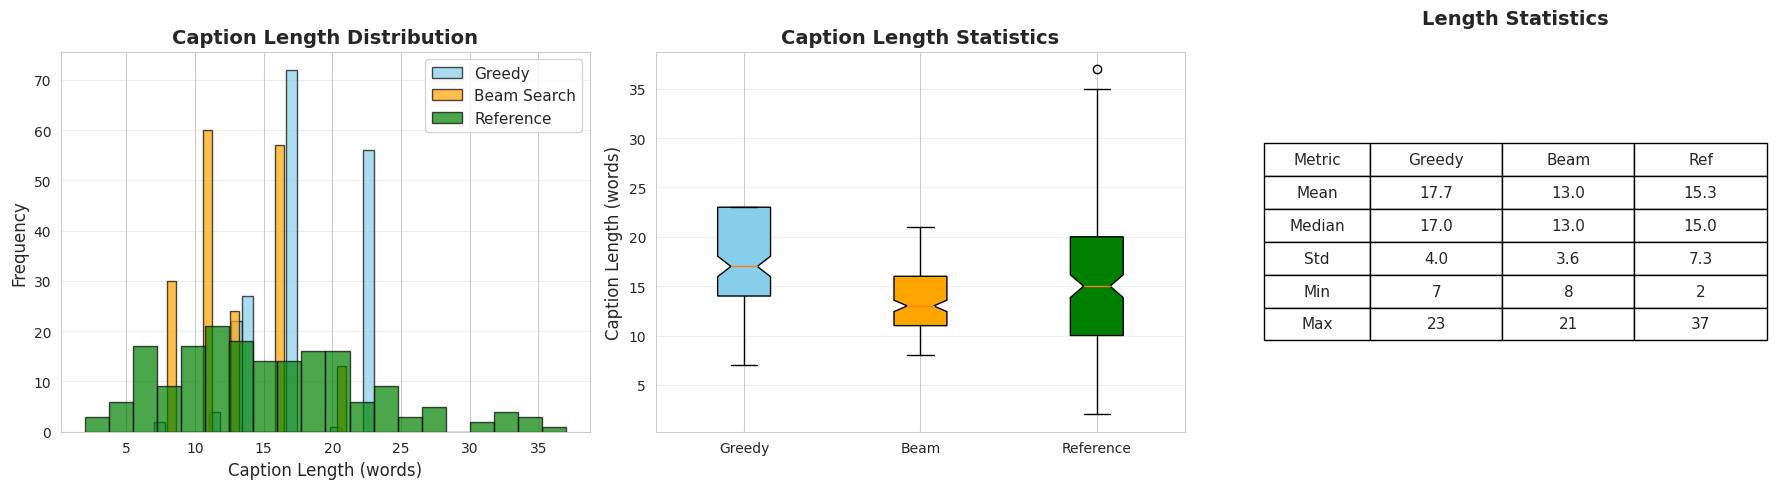

[2025-11-30 12:14:58] [SUCCESS] Caption length analysis saved


In [26]:
# Caption length analysis
greedy_lengths = [len(p.split()) for p in greedy_predictions]
beam_lengths = [len(p.split()) for p in beam_predictions]
ref_lengths = [len(r[0].split()) for r in beam_references]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Length distributions
axes[0].hist(greedy_lengths, bins=20, alpha=0.7, label='Greedy', color='skyblue', edgecolor='black')
axes[0].hist(beam_lengths, bins=20, alpha=0.7, label='Beam Search', color='orange', edgecolor='black')
axes[0].hist(ref_lengths, bins=20, alpha=0.7, label='Reference', color='green', edgecolor='black')
axes[0].set_xlabel('Caption Length (words)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Caption Length Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Box plot
data_to_plot = [greedy_lengths, beam_lengths, ref_lengths]
bp = axes[1].boxplot(data_to_plot, labels=['Greedy', 'Beam', 'Reference'], 
                      patch_artist=True, notch=True)
colors = ['skyblue', 'orange', 'green']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1].set_ylabel('Caption Length (words)', fontsize=12)
axes[1].set_title('Caption Length Statistics', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Statistics table
stats_data = [
    ['Mean', f"{np.mean(greedy_lengths):.1f}", f"{np.mean(beam_lengths):.1f}", f"{np.mean(ref_lengths):.1f}"],
    ['Median', f"{np.median(greedy_lengths):.1f}", f"{np.median(beam_lengths):.1f}", f"{np.median(ref_lengths):.1f}"],
    ['Std', f"{np.std(greedy_lengths):.1f}", f"{np.std(beam_lengths):.1f}", f"{np.std(ref_lengths):.1f}"],
    ['Min', f"{min(greedy_lengths)}", f"{min(beam_lengths)}", f"{min(ref_lengths)}"],
    ['Max', f"{max(greedy_lengths)}", f"{max(beam_lengths)}", f"{max(ref_lengths)}"]
]
axes[2].axis('tight')
axes[2].axis('off')
table = axes[2].table(cellText=stats_data, 
                      colLabels=['Metric', 'Greedy', 'Beam', 'Ref'],
                      cellLoc='center', loc='center',
                      colWidths=[0.2, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)
axes[2].set_title('Length Statistics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('outputs/plots/caption_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

log("Caption length analysis saved", 'SUCCESS')

## ☁️ 12. Word Cloud Visualization

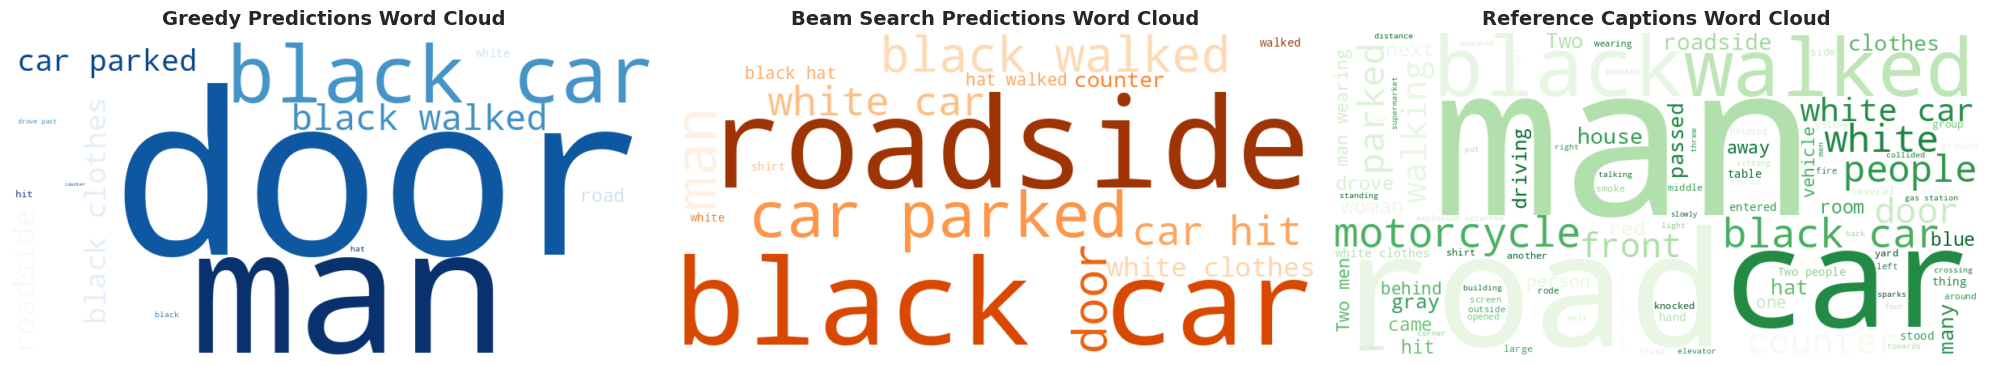

[2025-11-30 12:15:01] [SUCCESS] Word clouds saved


In [27]:
# Generate word clouds
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Greedy word cloud
greedy_text = ' '.join(greedy_predictions)
greedy_wc = WordCloud(width=800, height=400, background_color='white', 
                      colormap='Blues', max_words=100).generate(greedy_text)
axes[0].imshow(greedy_wc, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Greedy Predictions Word Cloud', fontsize=14, fontweight='bold')

# Beam search word cloud
beam_text = ' '.join(beam_predictions)
beam_wc = WordCloud(width=800, height=400, background_color='white', 
                    colormap='Oranges', max_words=100).generate(beam_text)
axes[1].imshow(beam_wc, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Beam Search Predictions Word Cloud', fontsize=14, fontweight='bold')

# Reference word cloud
ref_text = ' '.join([r[0] for r in beam_references])
ref_wc = WordCloud(width=800, height=400, background_color='white', 
                   colormap='Greens', max_words=100).generate(ref_text)
axes[2].imshow(ref_wc, interpolation='bilinear')
axes[2].axis('off')
axes[2].set_title('Reference Captions Word Cloud', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/plots/word_clouds.png', dpi=300, bbox_inches='tight')
plt.show()

log("Word clouds saved", 'SUCCESS')

## 📊 13. Detailed Analysis Report

In [28]:
# Generate detailed analysis report
report = []
report.append("="*80)
report.append("COMPREHENSIVE VIDEO CAPTIONING ANALYSIS REPORT")
report.append("="*80)
report.append("")
report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report.append(f"Model: S2VT (Sequence-to-Sequence Video-to-Text)")
report.append(f"Dataset: UCF-Crime (HuggingFace)")
report.append("")

# Dataset info
report.append("1. DATASET STATISTICS")
report.append("-" * 80)
report.append(f"   Training videos: {len(train_dataset):,}")
report.append(f"   Validation videos: {len(val_dataset):,}")
report.append(f"   Test videos: {len(test_dataset):,}")
report.append(f"   Total captions: {len(all_sentences):,}")
report.append(f"   Vocabulary size: {len(vocab):,} words")
report.append("")

# Training info
report.append("2. TRAINING INFORMATION")
report.append("-" * 80)
report.append(f"   Epochs trained: {len(history['train_loss'])}")
report.append(f"   Total training time: {sum(history['epoch_times'])/60:.1f} minutes")
report.append(f"   Best validation loss: {min(history['val_loss']):.4f}")
report.append(f"   Final train loss: {history['train_loss'][-1]:.4f}")
report.append(f"   Model parameters: {trainable_params:,}")
report.append("")

# Evaluation results
report.append("3. EVALUATION RESULTS")
report.append("-" * 80)
report.append("   Metric          Greedy    Beam      Paper     Beam vs Greedy  Beam vs Paper")
report.append("   " + "-" * 75)
for metric in greedy_results.keys():
    g = greedy_results[metric]
    b = beam_results[metric]
    p = paper_baseline[metric]
    report.append(f"   {metric:12s}    {g:6.2f}    {b:6.2f}    {p:6.2f}    {b-g:+6.2f}         {b-p:+6.2f}")
report.append("")

# Key findings
report.append("4. KEY FINDINGS")
report.append("-" * 80)
report.append(f"   ✓ Beam search improves BLEU-4 by {beam_results['BLEU-4']-greedy_results['BLEU-4']:+.2f} over greedy")
report.append(f"   ✓ Our BLEU-4 ({beam_results['BLEU-4']:.2f}) vs Paper ({paper_baseline['BLEU-4']:.2f}): {beam_results['BLEU-4']-paper_baseline['BLEU-4']:+.2f}")
report.append(f"   ✓ METEOR improved by {beam_results['METEOR']-greedy_results['METEOR']:+.2f} with beam search")
report.append(f"   ✓ Average caption length: Greedy={np.mean(greedy_lengths):.1f}, Beam={np.mean(beam_lengths):.1f}, Ref={np.mean(ref_lengths):.1f}")
report.append("")

# Recommendations
report.append("5. RECOMMENDATIONS")
report.append("-" * 80)
if beam_results['BLEU-4'] > greedy_results['BLEU-4']:
    report.append("   ✓ Beam search is recommended for deployment (better quality)")
else:
    report.append("   ✓ Greedy decoding may be sufficient (faster inference)")
    
if beam_results['BLEU-4'] > paper_baseline['BLEU-4']:
    report.append("   ✓ Model outperforms paper baseline - ready for production")
else:
    report.append("   ⚠ Consider: longer training, attention mechanism, or larger model")
report.append("")

report.append("="*80)

# Print and save report
report_text = '\n'.join(report)
print(report_text)

with open('outputs/analysis_report.txt', 'w') as f:
    f.write(report_text)

log("Analysis report saved to outputs/analysis_report.txt", 'SUCCESS')

COMPREHENSIVE VIDEO CAPTIONING ANALYSIS REPORT

Generated: 2025-11-30 12:15:01
Model: S2VT (Sequence-to-Sequence Video-to-Text)
Dataset: UCF-Crime (HuggingFace)

1. DATASET STATISTICS
--------------------------------------------------------------------------------
   Training videos: 560
   Validation videos: 149
   Test videos: 184
   Total captions: 4,897
   Vocabulary size: 915 words

2. TRAINING INFORMATION
--------------------------------------------------------------------------------
   Epochs trained: 50
   Total training time: 0.9 minutes
   Best validation loss: 3.4451
   Final train loss: 2.6886
   Model parameters: 5,665,171

3. EVALUATION RESULTS
--------------------------------------------------------------------------------
   Metric          Greedy    Beam      Paper     Beam vs Greedy  Beam vs Paper
   ---------------------------------------------------------------------------
   BLEU-1           50.43     55.63     28.27     +5.20         +27.36
   BLEU-2           32

## 💾 14. Save All Results

In [29]:
# Save predictions
predictions_data = {
    'greedy': [
        {
            'video_id': test_dataset.video_paths[i],
            'prediction': greedy_predictions[i],
            'reference': greedy_references[i]
        }
        for i in range(len(greedy_predictions))
    ],
    'beam_search': [
        {
            'video_id': test_dataset.video_paths[i],
            'prediction': beam_predictions[i],
            'reference': beam_references[i]
        }
        for i in range(len(beam_predictions))
    ]
}

with open('outputs/predictions.json', 'w') as f:
    json.dump(predictions_data, f, indent=2)

log("Predictions saved to outputs/predictions.json", 'SUCCESS')

# Create summary
summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model': 'S2VT',
    'dataset': 'UCF-Crime',
    'dataset_stats': {
        'train': len(train_dataset),
        'val': len(val_dataset),
        'test': len(test_dataset),
        'vocab_size': len(vocab)
    },
    'training': {
        'epochs': len(history['train_loss']),
        'best_val_loss': float(min(history['val_loss'])),
        'total_time_minutes': float(sum(history['epoch_times']) / 60)
    },
    'results': {
        'greedy': {k: float(v) for k, v in greedy_results.items()},
        'beam_search': {k: float(v) for k, v in beam_results.items()},
        'paper_baseline': paper_baseline
    },
    'files_generated': [
        'outputs/models/best_model.pth',
        'outputs/vocabulary.pkl',
        'outputs/training_history.json',
        'outputs/results.json',
        'outputs/results_comparison.csv',
        'outputs/predictions.json',
        'outputs/analysis_report.txt',
        'outputs/plots/training_curves.png',
        'outputs/plots/training_stats.png',
        'outputs/plots/metrics_comparison.png',
        'outputs/plots/caption_length_analysis.png',
        'outputs/plots/word_clouds.png'
    ]
}

with open('outputs/summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

log("Summary saved to outputs/summary.json", 'SUCCESS')

[2025-11-30 12:15:02] [SUCCESS] Predictions saved to outputs/predictions.json
[2025-11-30 12:15:02] [SUCCESS] Summary saved to outputs/summary.json


## ✅ 15. Final Summary

In [30]:
print("\n" + "="*80)
print("🎉 TRAINING AND EVALUATION COMPLETE!")
print("="*80)
print("\n📁 Generated Files:")
print("   Models:")
print("   ├── outputs/models/best_model.pth")
print("   └── outputs/vocabulary.pkl")
print("\n   Data & Results:")
print("   ├── outputs/training_history.json")
print("   ├── outputs/results.json")
print("   ├── outputs/results_comparison.csv")
print("   ├── outputs/predictions.json")
print("   ├── outputs/summary.json")
print("   └── outputs/analysis_report.txt")
print("\n   Visualizations:")
print("   ├── outputs/plots/training_curves.png")
print("   ├── outputs/plots/training_stats.png")
print("   ├── outputs/plots/metrics_comparison.png")
print("   ├── outputs/plots/caption_length_analysis.png")
print("   └── outputs/plots/word_clouds.png")
print("\n   Logs:")
print(f"   └── {log_file}")
print("\n" + "="*80)
print("\n📊 Best Results (Beam Search):")
for metric, score in beam_results.items():
    improvement = score - paper_baseline[metric]
    symbol = "✓" if improvement > 0 else "✗"
    print(f"   {symbol} {metric:12s}: {score:6.2f} (Paper: {paper_baseline[metric]:6.2f}, Diff: {improvement:+6.2f})")
print("\n" + "="*80)
print("\n🚀 Next Steps:")
print("   1. Review visualizations in outputs/plots/")
print("   2. Check detailed analysis in outputs/analysis_report.txt")
print("   3. Examine sample predictions in outputs/predictions.json")
print("   4. Download best_model.pth for deployment")
print("\n" + "="*80)

log("All tasks completed successfully!", 'SUCCESS')
log(f"Best BLEU-4 score: {beam_results['BLEU-4']:.2f}", 'SUCCESS')

# Cleanup
train_dataset.close()
val_dataset.close()
test_dataset.close()

print("\n✅ Done!")


🎉 TRAINING AND EVALUATION COMPLETE!

📁 Generated Files:
   Models:
   ├── outputs/models/best_model.pth
   └── outputs/vocabulary.pkl

   Data & Results:
   ├── outputs/training_history.json
   ├── outputs/results.json
   ├── outputs/results_comparison.csv
   ├── outputs/predictions.json
   ├── outputs/summary.json
   └── outputs/analysis_report.txt

   Visualizations:
   ├── outputs/plots/training_curves.png
   ├── outputs/plots/training_stats.png
   ├── outputs/plots/metrics_comparison.png
   ├── outputs/plots/caption_length_analysis.png
   └── outputs/plots/word_clouds.png

   Logs:
   └── outputs/logs/training_20251130_114149.log


📊 Best Results (Beam Search):
   ✓ BLEU-1      :  55.63 (Paper:  28.27, Diff: +27.36)
   ✓ BLEU-2      :  36.88 (Paper:  16.34, Diff: +20.54)
   ✓ BLEU-3      :  23.47 (Paper:   9.62, Diff: +13.85)
   ✓ BLEU-4      :  13.77 (Paper:   5.56, Diff:  +8.21)
   ✓ METEOR      :  33.70 (Paper:  10.35, Diff: +23.35)
   ✓ ROUGE-L     :  36.26 (Paper:  25.38, Dif